In [817]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import math

AVG_W        = 60  # trung bình 1 chữ số rộng ~16px
SMOOTH_WIN   = 15     # window size for moving‐average
VALLEY_DEPTH = 0.2   # chỉ split khi valley < 20% max projection

def split_roi(roi, avg_w=AVG_W):
    """
    Tách một vùng ROI có thể chứa >1 chữ số:
    1) Morphological closing để lấp lỗ
    2) Tính projection dọc → smoothing
    3) Tìm valley thỏa threshold
    4) Lọc valley quá gần nhau
    5) Nếu không đủ, fallback chia đều
    """
    # 1) Close holes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    clean  = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
    h, w   = clean.shape

    # estimate số chữ số n
    n = max(1, int(round(w / avg_w)))
    if n == 1:
        return [roi]

    # 2) Projection & smoothing
    proj   = np.sum(clean, axis=0)
    smooth = np.convolve(proj, np.ones(SMOOTH_WIN)/SMOOTH_WIN, mode='same')

    # 3) Raw valleys
    raw = [i for i in range(1, w-1)
           if smooth[i-1] > smooth[i] < smooth[i+1]]
    thr = VALLEY_DEPTH * np.max(smooth)
    valleys = [i for i in raw if smooth[i] < thr]

    # 5) Chọn điểm split
    if len(valleys) >= n-1:
        splits = sorted(valleys)[:n-1]
    else:
        splits = [i * (w // n) for i in range(1, n)]
    splits = sorted(set(splits))

    # 6) Thực sự cắt
    parts, prev = [], 0
    for sp in splits + [w]:
        part = roi[:, prev:sp]
        if part.shape[1] > 3:
            parts.append(part)
        prev = sp

    return parts

# --- Main extraction function ---
def extract_digits_from_dob(id_crop):
  

    # 1) Binarize
    gray   = cv2.cvtColor(id_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 3)
    thresh = cv2.adaptiveThreshold(
      blur, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C,
      cv2.THRESH_BINARY_INV,
      blockSize=33,  # odd window size, tweak between 11–31
      C=3         # constant subtracted from mean, tune 0–10
    )

    # 2) Find & sort contours
    cnts, _ = cv2.findContours(thresh,
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted((cv2.boundingRect(c) for c in cnts),
                   key=lambda b: b[0])

    digits = []
    for x, y, w, h in boxes:
        if h > 65 and w > 15:
            roi = thresh[y:y+h, x:x+w]
    

            # split ROI thành 1 hoặc nhiều chữ số
            subs = split_roi(roi)

            # với mỗi phần, pad vuông rồi resize về 28×28
            for part in subs:
                ph, pw = part.shape
                size   = max(ph, pw)
                dw, dh = size - pw, size - ph
                top,   bottom = dh//2, dh - dh//2
                left,  right  = dw//2, dw - dw//2

                padded = cv2.copyMakeBorder(
                    part,
                    top, bottom,
                    left, right,
                    borderType=cv2.BORDER_CONSTANT,
                    value=0
                )
                digit = cv2.resize(padded, (28, 28))
                digits.append(part)

    return digits

img1389.jpg → 9 digits
  Crop 0: shape = (95, 70)
  Crop 1: shape = (96, 66)
  Crop 2: shape = (96, 66)
  Crop 3: shape = (96, 66)
  Crop 4: shape = (96, 66)
  Crop 5: shape = (90, 34)
  Crop 6: shape = (90, 68)
  Crop 7: shape = (93, 58)
  Crop 8: shape = (91, 68)


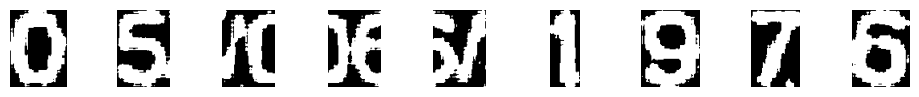

img1611.jpg → 9 digits
  Crop 0: shape = (96, 68)
  Crop 1: shape = (95, 66)
  Crop 2: shape = (95, 66)
  Crop 3: shape = (95, 66)
  Crop 4: shape = (95, 67)
  Crop 5: shape = (92, 36)
  Crop 6: shape = (91, 66)
  Crop 7: shape = (91, 66)
  Crop 8: shape = (91, 68)


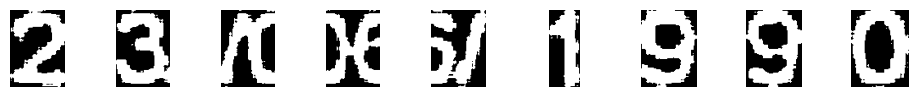

img1400.jpg → 9 digits
  Crop 0: shape = (86, 35)
  Crop 1: shape = (93, 61)
  Crop 2: shape = (103, 69)
  Crop 3: shape = (103, 69)
  Crop 4: shape = (103, 71)
  Crop 5: shape = (95, 41)
  Crop 6: shape = (94, 68)
  Crop 7: shape = (102, 68)
  Crop 8: shape = (102, 68)


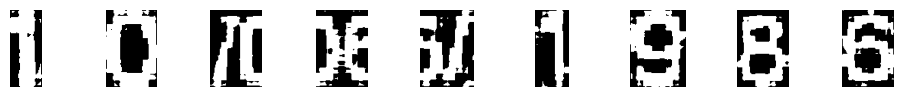

img1387.jpg → 9 digits
  Crop 0: shape = (91, 37)
  Crop 1: shape = (91, 69)
  Crop 2: shape = (92, 67)
  Crop 3: shape = (92, 67)
  Crop 4: shape = (92, 68)
  Crop 5: shape = (92, 40)
  Crop 6: shape = (96, 67)
  Crop 7: shape = (96, 67)
  Crop 8: shape = (96, 59)


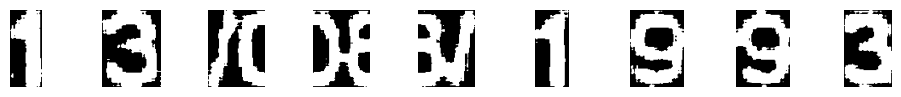


Total bad crops: 4 / 59


In [818]:
image_paths = glob.glob('cropped_dob_valid_640/*.jpg')
bad_count = 0
paths=[]
for path in image_paths:
    dob_crop = cv2.imread(path)

    digits   = extract_digits_from_dob(dob_crop)
    
    if len(digits) != 10 :
        
        bad_count += 1
        plt.figure(figsize=(12,1))
        print(f"{os.path.basename(path)} → {len(digits)} digits")
        paths.append(path)
        for i, digit in enumerate(digits):
            
            # print the shape of this crop
            print(f"  Crop {i}: shape = {digit.shape}")
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')

        plt.show()

print(f"\nTotal bad crops: {bad_count} / {len(image_paths)}")


In [821]:
# --- Main extraction function ---
def extract_digits_from_dob_1(id_crop):
  

    # 1) Binarize
    gray   = cv2.cvtColor(id_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm = clahe.apply(blur)
    thresh = cv2.adaptiveThreshold(
      norm, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C,
      cv2.THRESH_BINARY_INV,
      blockSize=27,  # odd window size, tweak between 11–31
      C=3         # constant subtracted from mean, tune 0–10
    )

    # 2) Find & sort contours
    cnts, _ = cv2.findContours(thresh,
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted((cv2.boundingRect(c) for c in cnts),
                   key=lambda b: b[0])

    digits = []
    for x, y, w, h in boxes:
        if h > 65 and w > 20:
            roi = thresh[y:y+h, x:x+w]

            # split ROI thành 1 hoặc nhiều chữ số
            subs = split_roi(roi)

            # với mỗi phần, pad vuông rồi resize về 28×28
            for part in subs:
                ph, pw = part.shape
                size   = max(ph, pw)
                dw, dh = size - pw, size - ph
                top,   bottom = dh//2, dh - dh//2
                left,  right  = dw//2, dw - dw//2

                padded = cv2.copyMakeBorder(
                    part,
                    top, bottom,
                    left, right,
                    borderType=cv2.BORDER_CONSTANT,
                    value=0
                )
                digit = cv2.resize(padded, (28, 28))
                digits.append(digit)

    return digits

img1389.jpg → 10 digits
  Crop 0: shape = (28, 28)
  Crop 1: shape = (28, 28)
  Crop 2: shape = (28, 28)
  Crop 3: shape = (28, 28)
  Crop 4: shape = (28, 28)
  Crop 5: shape = (28, 28)
  Crop 6: shape = (28, 28)
  Crop 7: shape = (28, 28)
  Crop 8: shape = (28, 28)
  Crop 9: shape = (28, 28)


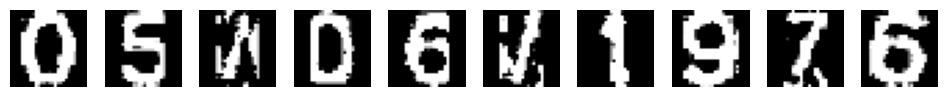

img1611.jpg → 10 digits
  Crop 0: shape = (28, 28)
  Crop 1: shape = (28, 28)
  Crop 2: shape = (28, 28)
  Crop 3: shape = (28, 28)
  Crop 4: shape = (28, 28)
  Crop 5: shape = (28, 28)
  Crop 6: shape = (28, 28)
  Crop 7: shape = (28, 28)
  Crop 8: shape = (28, 28)
  Crop 9: shape = (28, 28)


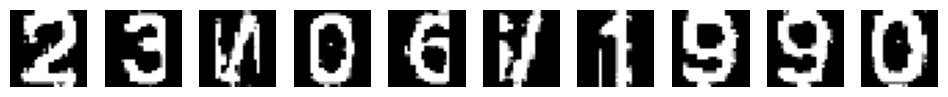

img1400.jpg → 10 digits
  Crop 0: shape = (28, 28)
  Crop 1: shape = (28, 28)
  Crop 2: shape = (28, 28)
  Crop 3: shape = (28, 28)
  Crop 4: shape = (28, 28)
  Crop 5: shape = (28, 28)
  Crop 6: shape = (28, 28)
  Crop 7: shape = (28, 28)
  Crop 8: shape = (28, 28)
  Crop 9: shape = (28, 28)


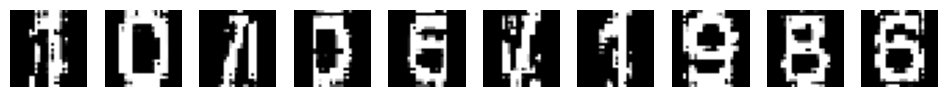

img1387.jpg → 10 digits
  Crop 0: shape = (28, 28)
  Crop 1: shape = (28, 28)
  Crop 2: shape = (28, 28)
  Crop 3: shape = (28, 28)
  Crop 4: shape = (28, 28)
  Crop 5: shape = (28, 28)
  Crop 6: shape = (28, 28)
  Crop 7: shape = (28, 28)
  Crop 8: shape = (28, 28)
  Crop 9: shape = (28, 28)


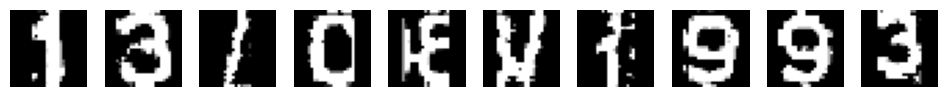


Total bad crops: 4 / 4


In [822]:
bad_count = 0
paths_ = []
for path in paths:
    dob_crop = cv2.imread(path)
    digits   = extract_digits_from_dob_1(dob_crop)
    
    if len(digits) == 10 :
        paths_.append(path)
        bad_count += 1
        plt.figure(figsize=(12,1))
        print(f"{os.path.basename(path)} → {len(digits)} digits")
        
        for i, digit in enumerate(digits):
            
            # print the shape of this crop
            print(f"  Crop {i}: shape = {digit.shape}")
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')

        plt.show()


print(f"\nTotal bad crops: {bad_count} / {len(paths)}")

In [735]:
# --- Main extraction function ---
def extract_digits_from_dob_2(id_crop):
  

    # 1) Binarize
    gray   = cv2.cvtColor(id_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 3)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
    norm = clahe.apply(blur)
    thresh = cv2.adaptiveThreshold(
      norm, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C,
      cv2.THRESH_BINARY_INV,
      blockSize=29,  # odd window size, tweak between 11–31
      C=2         # constant subtracted from mean, tune 0–10
    )


    # 2) Find & sort contours
    cnts, _ = cv2.findContours(thresh,
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted((cv2.boundingRect(c) for c in cnts),
                   key=lambda b: b[0])

    digits = []
    for x, y, w, h in boxes:
        if h > 65 and w > 20:
            roi = thresh[y:y+h, x:x+w]

            # split ROI thành 1 hoặc nhiều chữ số
            subs = split_roi(roi)

            # với mỗi phần, pad vuông rồi resize về 28×28
            for part in subs:
                ph, pw = part.shape
                size   = max(ph, pw)
                dw, dh = size - pw, size - ph
                top,   bottom = dh//2, dh - dh//2
                left,  right  = dw//2, dw - dw//2

                padded = cv2.copyMakeBorder(
                    part,
                    top, bottom,
                    left, right,
                    borderType=cv2.BORDER_CONSTANT,
                    value=0
                )
                digit = cv2.resize(padded, (28, 28))
                digits.append(part)

    return digits

img1346.jpg → 9 digits
  Crop 0: shape = (87, 67)
  Crop 1: shape = (87, 76)
  Crop 2: shape = (91, 61)
  Crop 3: shape = (91, 61)
  Crop 4: shape = (91, 62)
  Crop 5: shape = (86, 36)
  Crop 6: shape = (102, 62)
  Crop 7: shape = (102, 62)
  Crop 8: shape = (86, 82)


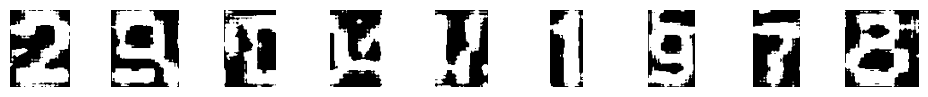


Total bad crops: 1 / 3


In [737]:
bad_count = 0
for path in paths_:
    dob_crop = cv2.imread(path)
    digits   = extract_digits_from_dob_2(dob_crop)
    
    if len(digits) != 10 :
        bad_count += 1
        plt.figure(figsize=(12,1))
        print(f"{os.path.basename(path)} → {len(digits)} digits")
        
        for i, digit in enumerate(digits):
            
            # print the shape of this crop
            print(f"  Crop {i}: shape = {digit.shape}")
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')

        plt.show()

print(f"\nTotal bad crops: {bad_count} / {len(paths_)}")